In [1]:
from ciml import gather_results
from ciml import tf_trainer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as pltcolors
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
#Define datapath
#data_path = '/Users/andreafrittoli/ciml/data'
data_path = '/Users/kw/ciml_data/datasets'

In [3]:
#dataset = 'size-mean-std-usr-status'
#dataset = '1m-usr-10S-status'
dataset = 'usr_1m-10s-node_provider'

In [4]:
#Dataset including classes
labels = gather_results.load_dataset(dataset, 'labels', data_path=data_path)['labels']
training_data = gather_results.load_dataset(dataset, 'training', data_path=data_path)
test_data = gather_results.load_dataset(dataset, 'test', data_path=data_path)
config = gather_results.load_model_config(dataset, data_path=data_path)
classes = training_data['classes']
examples = training_data['examples']
example_ids = training_data['example_ids']
# Create an int representation of class
unique_classes = list(set(classes))
dict_classes = dict(zip(unique_classes, list(range(len(unique_classes)))))
int_classes = [dict_classes[x] for x in classes]
df_data = pd.DataFrame(examples, columns=labels, index=example_ids)
df_data['classes'] = int_classes

In [11]:
unique_classes

['rax',
 'ovh',
 'packethost-us-west-1',
 'inap-mtl01',
 'vexxhost-sjc1',
 'vexxhost-ca-ymq-1',
 'limestone-regionone']

In [128]:
#***Use only for dataset with status binary
is_false = (df_data['classes'] == 1)
df_data_false = df_data[is_false]
df_data_false.shape
#print(df_data_false.head(2))

(140, 1101)

In [129]:
#***Use only for dataset with status false
column_false = df_data_false.shape[1]-1
cluster_examples = df_data_false.values[:,:column_false]
cluster_labels = labels
cluster_examples.shape

(140, 1100)

In [25]:
cluster_examples = df_data.values
cluster_labels = np.append([labels],['status'])

In [ ]:
#ifig = px.scatter_3d(df_data, x='usr_size', y='usr_mean', z='usr_std', color='classes')
ifig = px.scatter_3d(df_data, x='1m_size', y='1m_mean', z='1m_std', color='classes')
ifig.show()

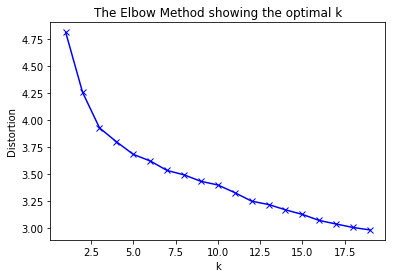

In [132]:
# k means determine k using elbow method
distortions = []
K = range(1,20)
X = cluster_examples
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.448962938038914
For n_clusters = 3 The average silhouette_score is : 0.18424831907921968
For n_clusters = 4 The average silhouette_score is : 0.16254431939472677
For n_clusters = 5 The average silhouette_score is : 0.16642043105067958
For n_clusters = 6 The average silhouette_score is : 0.09326549208639175
For n_clusters = 7 The average silhouette_score is : 0.13620202303512136
For n_clusters = 8 The average silhouette_score is : 0.12011445426361829


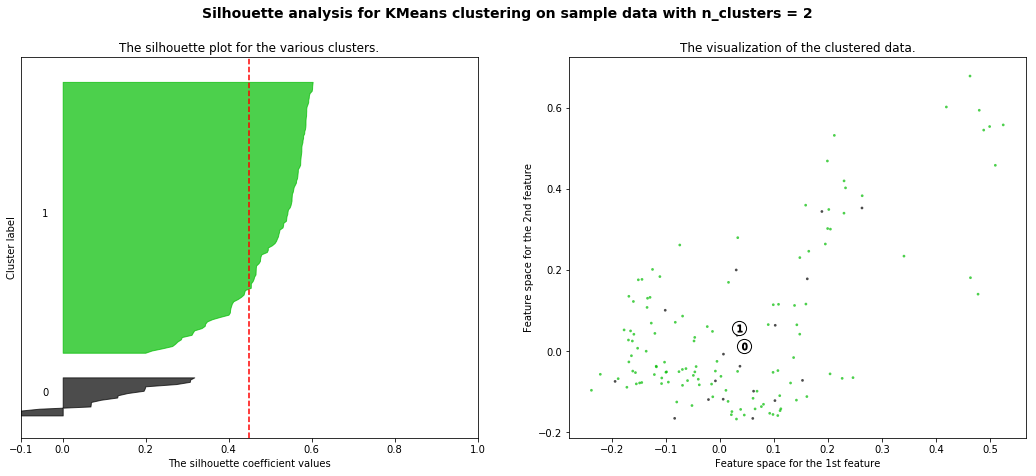

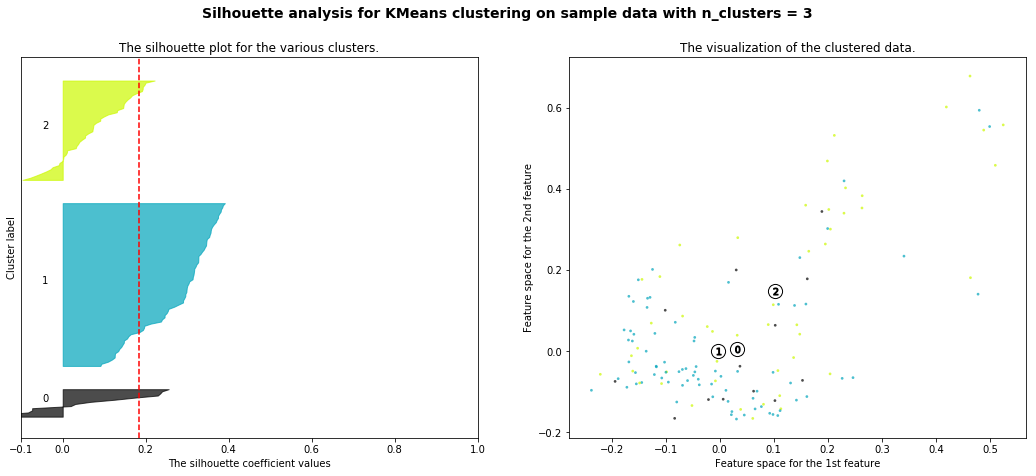

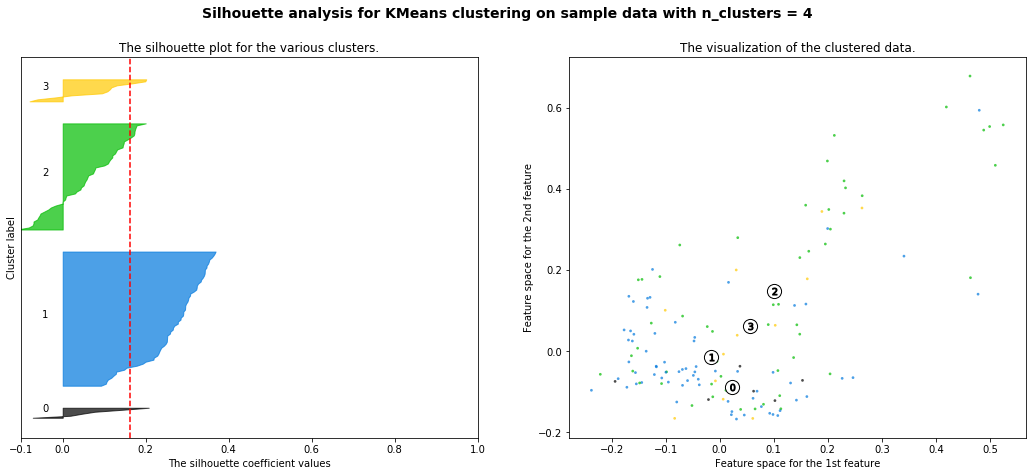

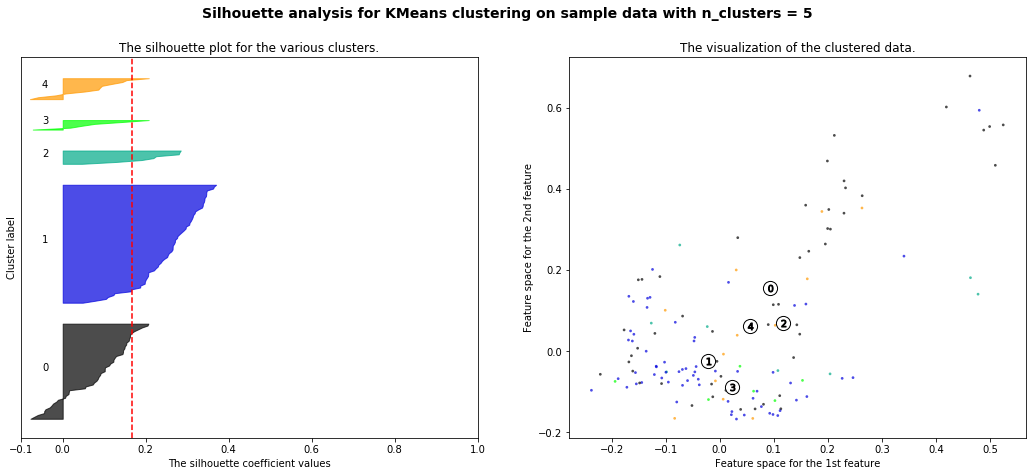

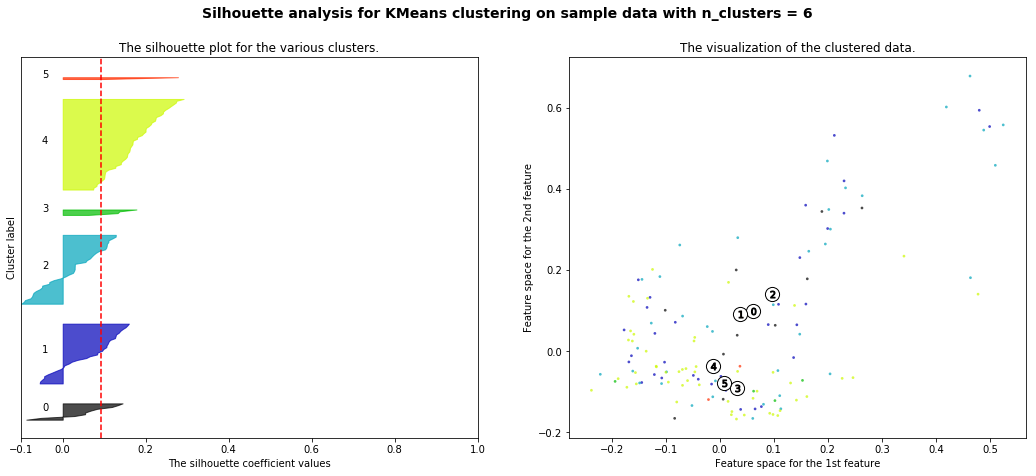

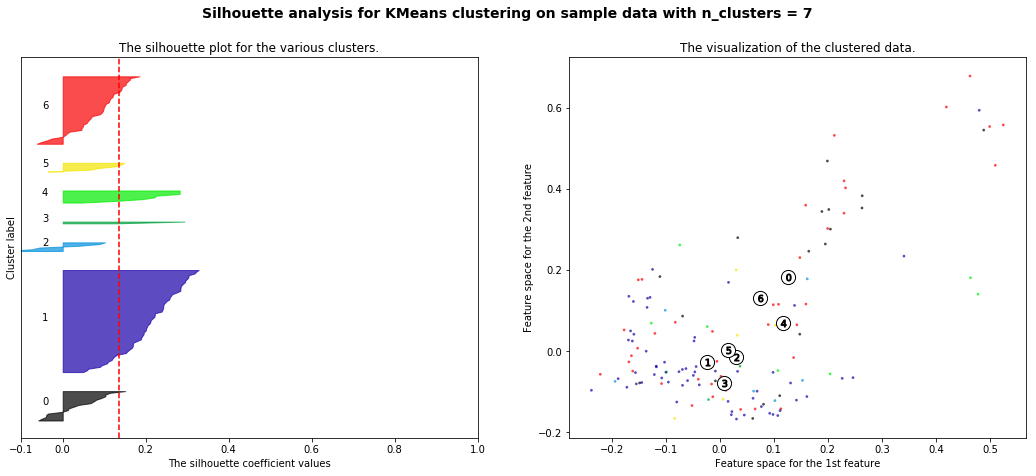

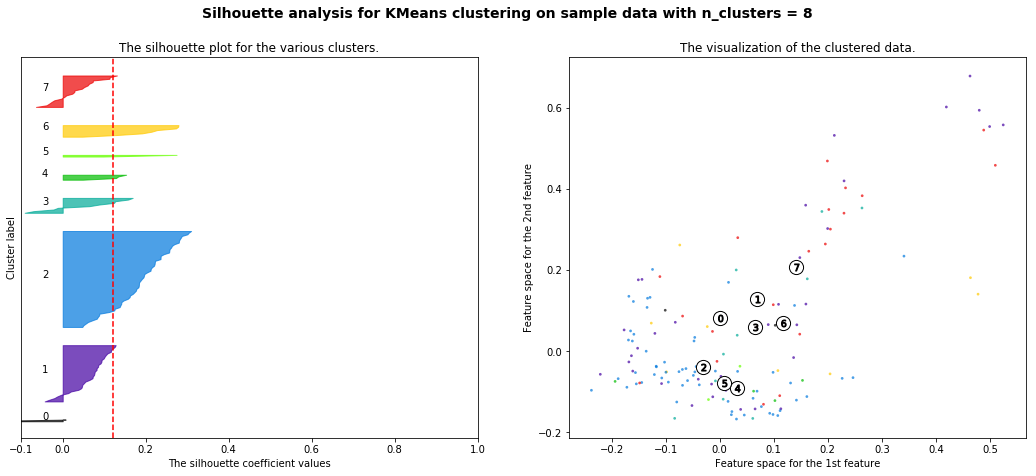

In [133]:
#Silhouette Score
#===============================================
#The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared 
#to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that 
#the object is well matched to its own cluster and poorly matched to neighboring clusters. 
#If most objects have a high value, then the clustering configuration is appropriate. 
#If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
#================================================
X = cluster_examples    
range_n_clusters = (2,3,4,5,6,7,8)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [81]:
#Define K-Means for training
kmeans = KMeans(n_clusters=7, n_init=200, n_jobs=4)
# Train K-Means
kmeans.fit(cluster_examples)
kmeans.predict(cluster_examples)
k_labels = kmeans.labels_
# Difference between fit and fit_predict: 
# With fit having attributes as _labels & _cluster_centers, with X data, 
#you can then estimate the goodness of the model using standard mis-classification penalty techniques. 
#you can't estimate anymore with fit_predict, since you will get only labels, and not cluster centers. 
# Train K-Means using fit_predict
#y_pred_kmeans = kmeans.fit_predict(training_data)
# Evaluate the K-Means clustering accuracy.
#metrics.acc(labels, y_pred_kmeans) -> syntax to point to passed/failed training_data

In [82]:
#***Use only for dataset with status false
#df_data_false = pd.DataFrame(cluster_examples, columns=labels, index=example_ids)
df_data_false['clusters'] = k_labels
#print(df_data_false.head(1))
df_data_false.groupby(by=['classes','clusters'])['clusters'].count()

classes  clusters
1        0           63
         1            4
         2           21
         3           11
         4            3
         5           28
         6           10
Name: clusters, dtype: int64

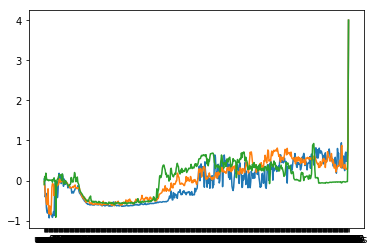

In [94]:
df_usr_false = df_data_false.drop(columns = ['1m' + str(ii) for ii in range(550)]) 
for _, row in df_usr_false.iterrows():
    if row['clusters'] == 4:
        plt.plot(row)
plt.show()

In [93]:
df_issue = df_usr_false[df_usr_false['clusters'] == 4] 
df_issue.tail()

,usr0,usr1,usr2,usr3,usr4,usr5,usr6,usr7,usr8,usr9,...,usr542,usr543,usr544,usr545,usr546,usr547,usr548,usr549,classes,clusters
0fccbf3b-a814-4b40-8d28-181e78ac1056,0.037483,-0.036800,-0.409340,-0.315309,-0.669179,-0.787190,-0.813521,-0.795189,-0.669152,-0.931605,...,0.611522,0.405642,0.248693,0.664886,0.710219,0.479858,0.642027,0.617807,1,4
f69b5c60-4fe1-44f2-8d0d-486545878d54,-0.020765,-0.118980,-0.328627,-0.417935,-0.561097,-0.600238,-0.532039,-0.205232,-0.721090,-0.834347,...,0.300800,0.314906,0.401141,0.370623,0.284706,0.281864,0.291005,0.298277,1,4
e9b475b0-2adf-4e6f-82fe-fdb9d8f7c887,-0.100774,0.101195,-0.004268,0.185300,0.073897,0.015775,0.015601,0.018652,-0.002176,0.003342,...,-0.028254,-0.027390,-0.034105,-0.039614,-0.033262,-0.025812,-0.024749,-0.024321,1,4


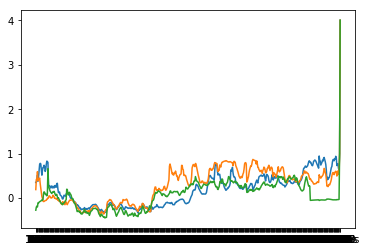

In [86]:
df_1m_false = df_data_false.drop(columns = ['usr' + str(ii) for ii in range(550)]) 
for _, row in df_1m_false.iterrows():
    if row['clusters'] == 4:
        plt.plot(row)
plt.show()

In [53]:
ifig = px.scatter_3d(df_data_false, x='usr80', y='usr90', z='usr100', color='clusters')
ifig.show()

In [27]:
df_data = pd.DataFrame(cluster_examples, columns=labels, index=example_ids)
df_data['classes'] = int_classes
df_data['clusters'] = k_labels
#df_data['gaussian'] = colored_tuples
#ifig = px.scatter_3d(df_data, x='usr_mean', y='usr_size', z='usr_std', color='clusters', symbol='classes')
#ifig = px.scatter_3d(df_data, x='1m_mean', y='1m_size', z='1m_std', color='clusters', symbol='classes')
#ifig.show()
df_data

,usr0,usr1,usr2,usr3,usr4,usr5,usr6,usr7,usr8,usr9,...,1m542,1m543,1m544,1m545,1m546,1m547,1m548,1m549,classes,clusters
cec7fcef-37d1-4e72-8ffb-83017b64c30e,-0.171712,-0.088621,0.097000,-0.118786,0.027070,-0.021537,-0.024221,-0.014663,-0.027398,-0.027224,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,1,1
7034de04-27d5-40db-9adb-6d5db5655a31,-0.140044,0.079240,0.085423,-0.033625,0.074914,0.018390,0.026559,0.008847,0.009363,-0.000615,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,0
0091a317-0034-416a-805e-0ae339d22af3,0.127775,-0.091468,-0.027564,-0.012630,0.049124,0.003685,0.008303,0.009866,0.005228,0.013627,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,0
73dec466-c9e4-4e5f-82d8-abbb817d3921,-0.141174,0.028930,0.048211,-0.106551,0.072115,0.016177,0.005603,0.010767,0.010651,0.009192,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,1
2d4e7a77-bab6-4f4c-8845-56328d791f21,0.220255,-0.085291,-0.105983,0.147276,-0.081161,0.015464,-0.010163,0.003095,0.005661,0.003820,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,1
5619b3cd-9b94-4792-87ed-24bfb3aa2a8a,0.339157,-0.020532,0.198793,-0.036400,0.064666,0.027177,-0.003964,0.008532,0.005129,0.016115,...,0.320162,0.308562,0.273763,0.239669,0.266878,0.296319,0.280660,0.252283,0,0
e3805971-245c-43f4-8d41-cd9de19355ce,-0.019528,-0.081518,-0.226019,0.058602,-0.120347,0.048177,0.036890,0.034404,0.041917,0.041570,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,1
a022a4e6-85c0-46ba-9701-8f560d96dcf6,0.105728,-0.084604,-0.077434,0.220262,-0.136216,0.009513,-0.021121,-0.005232,-0.002491,-0.007691,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,1
ddff2483-56b0-4a51-b736-be53e7fc6811,-0.061631,-0.023351,0.020606,0.011393,0.092922,0.029365,0.018407,0.026605,0.033504,0.010012,...,0.197869,0.229599,0.252795,0.223998,0.243545,0.257714,0.227369,0.224436,0,0
925f88bf-e6df-41e6-90b6-15a61ca9eb1c,0.121169,-0.101900,-0.080338,0.157961,-0.146538,-0.020127,-0.044380,-0.027255,-0.025056,-0.042448,...,-0.038806,-0.040251,-0.040020,-0.033714,-0.034019,-0.034914,-0.031349,-0.029640,0,1


In [ ]:
#df_data['clusters'].value_counts()
df_data.groupby(by=['classes','clusters'])['clusters'].count()

In [ ]:
ifig = px.scatter_3d(df_data_false, x='1m_mean', y='1m_size', z='1m_std', color='clusters')
ifig.show()

In [ ]:
df_data_false.groupby(by=['classes','clusters'])['clusters'].count()

In [ ]:
df_data.loc[df_data['clusters'] == 6]

In [ ]:
df_data.loc[df_data['classes'] == 1].min()

In [ ]:
df_data.loc[df_data['classes'] == 0].min()

In [ ]:
df_data.min()

In [ ]:
df_data.max()

In [ ]:
df_data.loc[df_data['clusters'] == 6].min()

In [ ]:
df_data.loc[df_data['clusters'] == 1].min()

In [ ]:
df_data.loc[df_data['clusters'] == 6].max()

In [ ]:
df_data.loc[df_data['clusters'] == 1].max()

In [ ]:
df_data


In [ ]:
#ifig = px.scatter_3d(df_data, x='used_mean', y='used_size', z='used_std', color='classes')
#ifig.show()

In [ ]:
ifig = px.scatter_3d(df_data, x='usr_mean', y='usr_size', z='usr_std', color='clusters')
ifig.show()

In [ ]:
ifig = px.scatter_3d(df_data, x='usr_mean', y='usr_size', z='usr_std', color='cluster')
ifig.show()

In [ ]:
#Gaussian Mixture Model
gmm = GaussianMixture(n_components=3)
gmm.fit(examples)
proba_lists = gmm.predict_proba(examples)

In [ ]:
colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colored_tuples[0]
#color_dict = {0:"r",1:"g",2:"b"}
#color_array = [color_dict[i] for i in proba_lists]
#plt.scatter(range(len(examples)), examples, c=color_array)
#plt.title("Gaussian Model")

In [ ]:
ifig = px.scatter_3d(df_data, x='usr_mean', y='usr_size', z='usr_std', color='gaussian')
ifig.show()

In [ ]:
k_labels

In [ ]:
type(int_classes)